In [51]:
import g3lhalo
import pyccl as ccl
import matplotlib.pyplot as plt
import numpy as np

In [52]:
# !pip install ../

# Example for Aperture Statistics

We show here how to calculate the aperture statistics

In [53]:
# Cosmology
cosmo = {
    'Om_c': 0.28,
    'Om_b': 0.05,
    'h': 0.67,
    'sigma_8': 0.8,
    'n_s': 0.96
}

# Halo mass function
hmf=ccl.halos.MassFuncSheth99()

# Halo bias
hbf=ccl.halos.HaloBiasSheth01()

# Concentration mass Relation
cmfunc=ccl.halos.ConcentrationDuffy08()


# HOD
# HOD parameters
alpha=1
sigma=0.2
Mth=1e12
Mprime=20*Mth
beta=1

# Correlation between galaxy populations
A=0 # 0 ==> No correlation between populations
epsilon=0

# Scaling of halo profile concentration
flens=1 # 1 ==> Same as dark matter

# Get HOD
hod_cen, hod_sat = g3lhalo.HOD_Zheng(alpha, Mth, sigma, Mprime, beta)

# Define model
model = g3lhalo.halomodel(verbose=True, cosmo=cosmo, hmfunc=hmf, hbfunc=hbf, cmfunc=cmfunc)
model.set_hods(hod_cen, hod_sat, A=A, epsilon=epsilon, flens1=flens, flens2=flens)




Setting cosmology
Om_c: 0.28
Om_b: 0.05
h: 0.67
sigma_8: 0.8
n_s: 0.96
Also setting linear matter power spectrum
Setting halo mass function
<pyccl.halos.hmfunc.sheth99.MassFuncSheth99>
	mass_def = MassDef(Delta=fof, rho_type=matter)
Setting halo bias function
<pyccl.halos.hbias.sheth01.HaloBiasSheth01>
	mass_def = MassDef(Delta=fof, rho_type=matter)
Setting concentration mass relation
<pyccl.halos.concentration.duffy08.ConcentrationDuffy08>
	mass_def = MassDef(Delta=200, rho_type=critical)
	mass_def_strict = True


In [54]:
zs=np.linspace(0.2, 1.5)

n_sources=np.exp(-(zs-1)**2/0.02**2)
n_lenses=np.exp(-(zs-0.5)**2/0.02**2)

n_sources/=(np.sum(n_sources)*(zs[1]-zs[0]))
n_lenses/=(np.sum(n_lenses)*(zs[1]-zs[0]))


Text(0, 0.5, '$n(z)$')

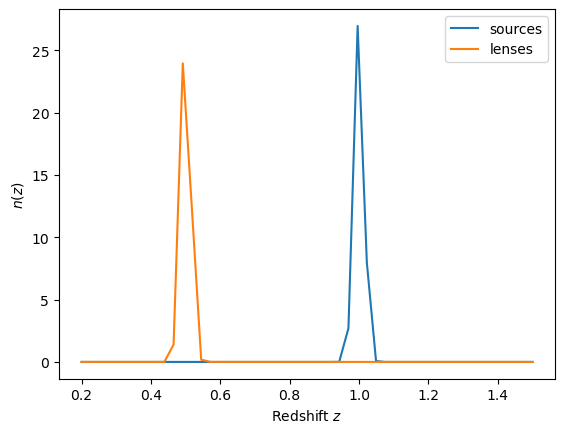

In [55]:

plt.plot(zs, n_sources, label="sources")

plt.plot(zs, n_lenses, label='lenses')


plt.legend()
plt.xlabel(r"Redshift $z$")
plt.ylabel(r"$n(z)$")

In [56]:
projection=g3lhalo.projectedSpectra(model)

projection.set_nz_lenses(zs, n_lenses)
projection.set_nz_sources(zs, n_sources)

In [57]:
# Precompute power spectra

ells=np.geomspace(1, 20000, 20)

# convergence-convergence
C_kk_1h, C_kk_2h, C_kk=projection.C_kk(ells)

C_kk_dict={
    'ell': ells,
    'ps': C_kk
}

# convergence-galaxies
C_kg_1h, C_kg_2h, C_kg=projection.C_kg(ells, 1)

C_kg_dict={
    'ell': ells,
    'ps': C_kg
}

# galaxies-galaxies
C_gg_1h, C_gg_2h, C_gg=projection.C_gg(ells, 1, 1)

C_gg_dict={
    'ell': ells,
    'ps': C_gg
}

In [58]:
thetas=np.geomspace(2, 200, 10)


In [59]:
# Aperture statistics: Map2

Map2_calculator = g3lhalo.apertureStatistics(powerspec=C_kk_dict)
Map2=[]

for th in thetas:
    th_rad=np.deg2rad(th/60)
    Map2.append(Map2_calculator.second_order(th_rad))


In [60]:
# Aperture statistics: MapNap

MapNap_calculator = g3lhalo.apertureStatistics(powerspec=C_kg_dict)
MapNap=[]

for th in thetas:
    th_rad=np.deg2rad(th/60)
    MapNap.append(MapNap_calculator.second_order(th_rad))


In [61]:
# Aperture statistics: NapNap

NapNap_calculator = g3lhalo.apertureStatistics(powerspec=C_gg_dict)
NapNap=[]

for th in thetas:
    th_rad=np.deg2rad(th/60)
    NapNap.append(NapNap_calculator.second_order(th_rad))


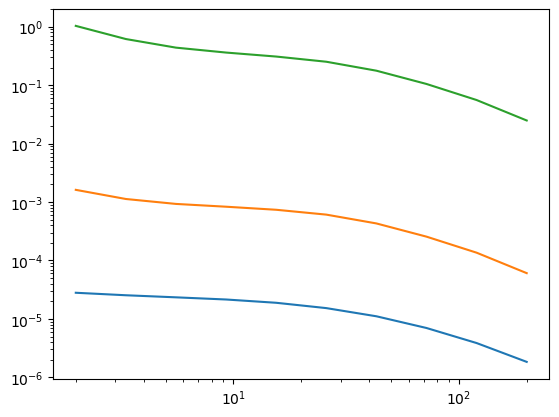

In [62]:
plt.loglog(thetas, Map2, label='MM')
plt.loglog(thetas, MapNap, label='MN')
plt.loglog(thetas, NapNap, label='NN')




In [63]:
# Precompute bi spectra

ells1=np.geomspace(1, 20000, 20)
ells2=np.geomspace(1, 20000, 20)
phis=np.linspace(0, 2*np.pi, 20)

# matter-galaxy-galaxy

Bs_kgg=np.zeros((len(ells1), len(ells2), len(phis)))
for i, ell1 in enumerate(ells1):
    for j, ell2 in enumerate(ells2):
        for k, phi in enumerate(phis):

            ell3=np.sqrt(ell1**2+ell2**2+2*np.cos(phi)*ell1*ell2)

            B1h, B2h, B3h, B=projection.C_kgg(ell1, ell2, ell3, 1, 1)
            Bs_kgg[i, j, k]=B


B_kgg_dict={
    'ell1': ells1,
    'ell2': ells2,
    'phi': phis, 
    'bs': Bs_kgg
}

In [64]:
# Aperture statistics: MapNapNap
thetas=np.geomspace(2, 200, 10)



MapNapNap_calculator = g3lhalo.apertureStatistics(bispec=B_kgg_dict)
MapNapNap=[]

for th in thetas:
    print(th)
    th_rad=np.deg2rad(th/60)
    MapNapNap.append(MapNapNap_calculator.third_order(th_rad, th_rad, th_rad))


2.0
3.3362010744001167
5.565118804414249
9.283177667225555
15.485273653622542
25.830993300297685
43.08869380063767
71.87627327609252
119.8968500637882
200.0


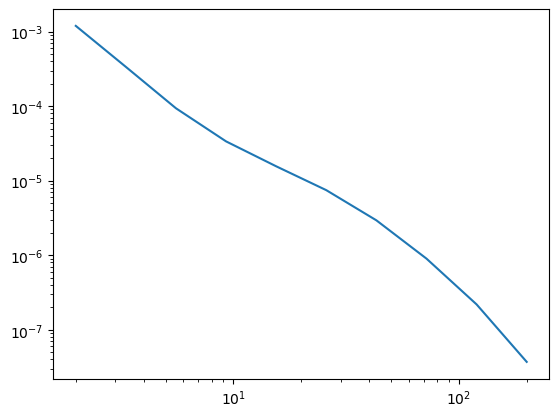

In [65]:
plt.loglog(thetas, MapNapNap)

In [66]:
# matter-matter-galaxy

Bs_kkg=np.zeros((len(ells1), len(ells2), len(phis)))
for i, ell1 in enumerate(ells1):
    for j, ell2 in enumerate(ells2):
        for k, phi in enumerate(phis):

            ell3=np.sqrt(ell1**2+ell2**2+2*np.cos(phi)*ell1*ell2)

            B1h, B2h, B3h, B=projection.C_kkg(ell1, ell2, ell3, 1)
            Bs_kkg[i, j, k]=B

B_kkg_dict={
    'ell1': ells1,
    'ell2': ells2,
    'phi': phis, 
    'bs': Bs_kgg
}

In [67]:
# Aperture statistics: MapMapNap

MapMapNap_calculator = g3lhalo.apertureStatistics(bispec=B_kkg_dict)
MapMapNap=[]

for th in thetas:
    th_rad=np.deg2rad(th/60)
    MapMapNap.append(MapMapNap_calculator.third_order(th_rad, th_rad, th_rad))


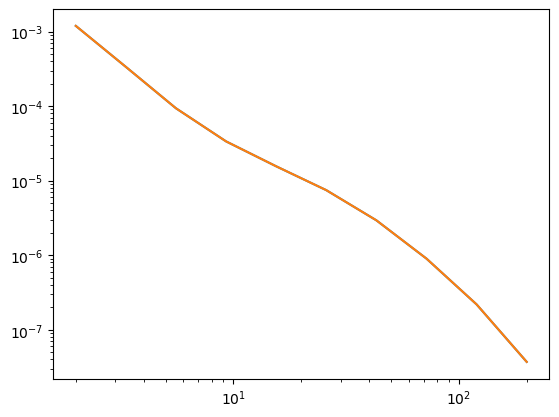

In [68]:
plt.loglog(thetas, MapMapNap, label='MMN')
plt.loglog(thetas, MapNapNap, label='MNN')




In [69]:
# Precompute bi spectra

ells1=np.geomspace(1, 20000, 20)
ells2=np.geomspace(1, 20000, 20)
phis=np.linspace(0, 2*np.pi, 20)

# matter-matter-matter

Bs_kkk=np.zeros((len(ells1), len(ells2), len(phis)))
for i, ell1 in enumerate(ells1):
    for j, ell2 in enumerate(ells2):
        for k, phi in enumerate(phis):

            ell3=np.sqrt(ell1**2+ell2**2+2*np.cos(phi)*ell1*ell2)

            B1h, B2h, B3h, B=projection.C_kkk(ell1, ell2, ell3)
            Bs_kgg[i, j, k]=B


B_kkk_dict={
    'ell1': ells1,
    'ell2': ells2,
    'phi': phis, 
    'bs': Bs_kgg
}

In [70]:
# Aperture statistics: MapMapMap

MapMapMap_calculator = g3lhalo.apertureStatistics(bispec=B_kkk_dict)
MapMapMap=[]

for th in thetas:
    th_rad=np.deg2rad(th/60)
    MapMapMap.append(MapMapMap_calculator.third_order(th_rad, th_rad, th_rad))


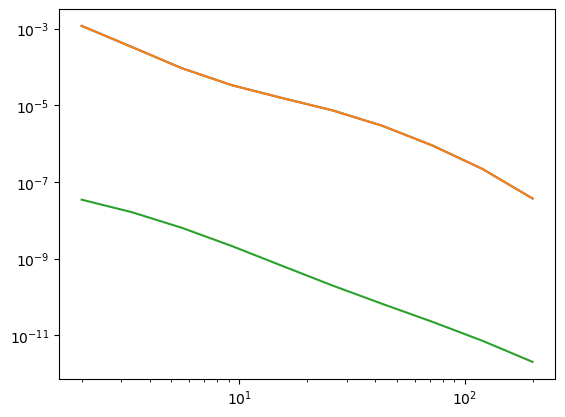

In [73]:
plt.loglog(thetas, MapMapNap, label='MMN')
plt.loglog(thetas, MapNapNap, label='MNN')
plt.loglog(thetas, np.array(MapMapMap), label='MMM')





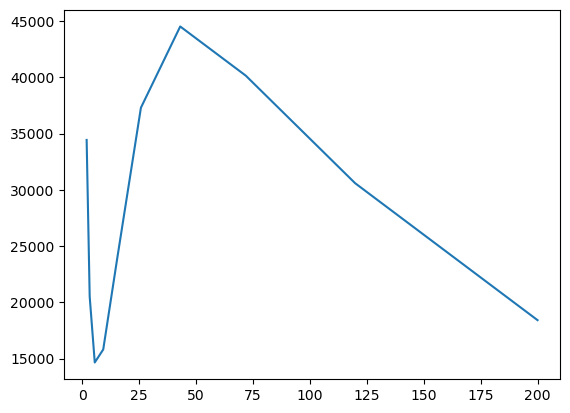

In [72]:
plt.plot(thetas, np.array(MapNapNap)/np.array(MapMapMap))